In [ ]:
import pandas as pd
import requests
import logging
from core.DataFetcher import DataFetcher
from core.IVSimplifier import IVSimplifier
from core.MultiCompanyAggregator import MultiCompanyAggregator  # Replace with your import path


logging.basicConfig(level=logging.INFO)


def get_sp500_tickers_from_wikipedia() -> list:
    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/115.0 Safari/537.36"
    }
    response = requests.get(url, headers=headers)
    response.raise_for_status()

    tables = pd.read_html(response.text)
    sp500_table = tables[0]
    
    tickers = sp500_table['Symbol'].tolist()
    tickers = [t.replace('.', '-') for t in tickers]  # For yfinance compatibility
    return tickers


def main():
    test_tickers = get_sp500_tickers_from_wikipedia()
    print(f"Retrieved {len(test_tickers)} tickers from Wikipedia S&P 500 list.")

    try:
        aggregator = MultiCompanyAggregator(DataFetcher, IVSimplifier, max_workers=5, delay=0.5)

        print("Starting data fetch for multiple companies...")
        aggregator.fetch_multiple_companies(test_tickers, use_concurrent=True)

        print("\nCreating combined DataFrame using key metrics for all years...")
        combined = aggregator.create_combined_dataframe(
            metrics=['Basic EPS', 'Free Cash Flow', 'P/E Ratio', 'Share Price'],
            latest_year_only=False
        )

        aggregator.display_summary()

        print("\nPreview combined data (first 5 rows):")
        print(combined.head())

        print("\nSector summary for P/E Ratio:")
        sector_summary = aggregator.get_sector_summary('P/E Ratio')
        print(sector_summary)

        print("\nTop 3 companies by Market Cap:")
        top_companies = aggregator.get_top_companies('Market Cap', n=3)
        print(top_companies[['Ticker', 'Company', 'Market Cap', 'P/E Ratio']])

        # Uncomment to export results
        aggregator.export_to_csv('aggregated_data.csv')
        print("Export complete.")

    except Exception as e:
        print(f"Test failed with error: {e}")


if __name__ == "__main__":
    main()


C:\Users\joao_\AppData\Local\Temp\ipykernel_21364\792341055.py:20: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(response.text)
INFO:core.DataFetcher:Fetching data for MMM...
INFO:core.DataFetcher:Fetching data for AOS...
INFO:core.DataFetcher:Fetching data for ABT...
INFO:core.DataFetcher:Fetching data for ABBV...
INFO:core.DataFetcher:Fetching data for ACN...


Retrieved 503 tickers from Wikipedia S&P 500 list.
Starting data fetch for multiple companies...


INFO:core.DataFetcher:Creating enhanced dataset with 4 periods...
INFO:core.DataFetcher:Successfully created comprehensive dataset: (64, 4)
INFO:core.IVSimplifier:Transformed 4 columns to year-based format
INFO:core.IVSimplifier:Filtered to 19 essential metrics
INFO:core.DataFetcher:Fetching data for ADBE...
INFO:core.DataFetcher:Creating enhanced dataset with 4 periods...
INFO:core.DataFetcher:Successfully created comprehensive dataset: (65, 4)
INFO:core.IVSimplifier:Transformed 4 columns to year-based format
INFO:core.IVSimplifier:Filtered to 19 essential metrics
INFO:core.DataFetcher:Fetching data for AMD...
INFO:core.DataFetcher:Creating enhanced dataset with 4 periods...
INFO:core.DataFetcher:Successfully created comprehensive dataset: (56, 4)
INFO:core.IVSimplifier:Transformed 4 columns to year-based format
INFO:core.IVSimplifier:Filtered to 19 essential metrics
INFO:core.DataFetcher:Fetching data for AES...
INFO:core.DataFetcher:Creating enhanced dataset with 5 periods...
INFO:c

In [2]:
import pandas as pd
combined_df = pd.read_csv('aggregated_data.csv')

In [3]:
combined_df = convert_to_sequential_years(combined_df)
print(combined_df.head())


NameError: name 'convert_to_sequential_years' is not defined

In [ ]:
technology_df = combined_df[combined_df['Sector'] == 'Technology']
healthcare_df = combined_df[combined_df['Sector'] == 'Healthcare']
industrials_df = combined_df[combined_df['Sector'] == 'Industrials']
basic_materials_df = combined_df[combined_df['Sector'] == 'Basic Materials']
financials_df = combined_df[combined_df['Sector'] == 'Financial Services']
energy_df = combined_df[combined_df['Sector'] == 'Energy']
consumer_cyclicals_df = combined_df[combined_df['Sector'] == 'Consumer Cyclicals']
utilities_df = combined_df[combined_df['Sector'] == 'Utilities']
real_estate_df = combined_df[combined_df['Sector'] == 'Real Estate']
consumer_defensive_df = combined_df[combined_df['Sector'] == 'Consumer Defensive']
communication_services_df = combined_df[combined_df['Sector'] == 'Communication Services']




In [ ]:
technology_df

NameError: name 'technology_df' is not defined

In [ ]:
communication_services_df.head()

,Ticker,Company,Sector,Industry,Market Cap,Year,Basic EPS,Free Cash Flow,P/E Ratio,Share Price,Sequential_Year
152,APP,AppLovin Corporation,Communication Services,Advertising Agencies,191050317824,2021,0.10,3.604610e+08,942.600021,94.260002,1
153,APP,AppLovin Corporation,Communication Services,Advertising Agencies,191050317824,2022,-0.52,4.121110e+08,-20.249999,10.530000,2
154,APP,AppLovin Corporation,Communication Services,Advertising Agencies,191050317824,2023,1.01,1.057264e+09,39.455444,39.849998,3
155,APP,AppLovin Corporation,Communication Services,Advertising Agencies,191050317824,2024,4.68,2.094235e+09,69.194442,323.829987,4
353,CHTR,"Charter Communications, Inc.",Communication Services,Telecom Services,33456596992,2021,25.34,8.684000e+09,25.728886,651.969971,1


In [ ]:
def compute_weighted_multiple(df, metrics):
    results = {}
    for metric in metrics:
        weighted_avg = (df[metric] * df['Market Cap']).sum() / df['Market Cap'].sum()
        results[metric] = weighted_avg
    return results


In [ ]:
metrics = ['Basic EPS', 'P/E Ratio', 'Free Cash Flow']
weighted_metrics_technology = technology_df.groupby('Sequential_Year').apply(lambda x: compute_weighted_multiple(x, metrics))


C:\Users\joao_\AppData\Local\Temp\ipykernel_67400\3570494805.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_metrics_technology = technology_df.groupby('Sequential_Year').apply(lambda x: compute_weighted_multiple(x, metrics))


In [ ]:
weighted_metrics_technology.head()

Sequential_Year
1    {'Basic EPS': 4.111064765301287, 'P/E Ratio': ...
2    {'Basic EPS': 4.28613042376358, 'P/E Ratio': 5...
3    {'Basic EPS': 5.269437119638032, 'P/E Ratio': ...
4    {'Basic EPS': 6.338865052546328, 'P/E Ratio': ...
5    {'Basic EPS': 0.0, 'P/E Ratio': 0.0, 'Free Cas...
dtype: object

In [ ]:


# If `combined_series` is your Series indexed by Sequential_Year with nested dicts as values
weighted_metrics_technology = weighted_metrics_technology.reset_index()  # Make Sequential_Year a column

weighted_metrics_technology_df = pd.json_normalize(weighted_metrics_technology[0])

# Combine Sequential_Year with the expanded columns
weighted_metrics_technology_df = pd.concat([weighted_metrics_technology['Sequential_Year'], weighted_metrics_technology_df], axis=1)

print(weighted_metrics_technology_df.head())


   Sequential_Year  Basic EPS  P/E Ratio  Free Cash Flow
0                1   4.111065  40.498285    1.938147e+10
1                2   4.286130  55.639705    1.747733e+10
2                3   5.269437  66.961079    2.713353e+10
3                4   6.338865  12.859342    3.498684e+10
4                5   0.000000   0.000000    7.792043e+09


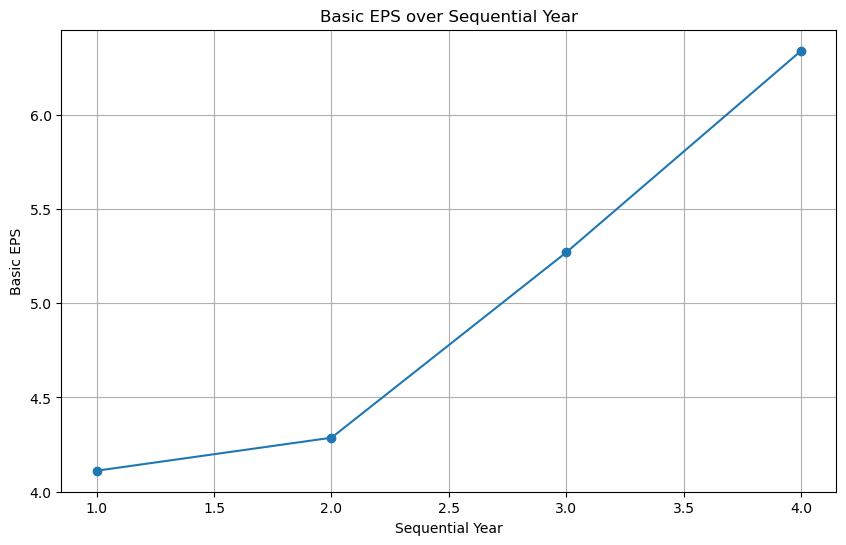

In [ ]:
import matplotlib.pyplot as plt

weighted_metrics_technology_df = weighted_metrics_technology_df[weighted_metrics_technology_df['Basic EPS'] != 0]

# Assuming combined_df already has a Sequential_Year column and Basic EPS column
plt.figure(figsize=(10,6))
plt.plot(weighted_metrics_technology_df['Sequential_Year'], weighted_metrics_technology_df['Basic EPS'], marker='o', linestyle='-')

plt.title('Basic EPS over Sequential Year')
plt.xlabel('Sequential Year')
plt.ylabel('Basic EPS')
plt.grid(True)
plt.show()


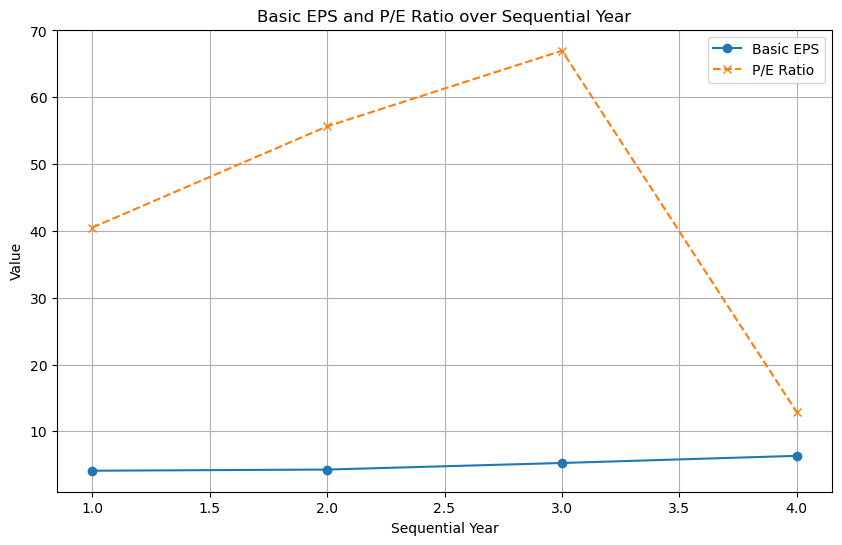

In [ ]:
import matplotlib.pyplot as plt

# Drop rows where Basic EPS is 0 if needed
weighted_metrics_technology_df = weighted_metrics_technology_df[weighted_metrics_technology_df['Basic EPS'] != 0]
weighted_metrics_technology_df = weighted_metrics_technology_df[weighted_metrics_technology_df['P/E Ratio'] != 0]


plt.figure(figsize=(10,6))

# Plot Basic EPS
plt.plot(weighted_metrics_technology_df['Sequential_Year'], weighted_metrics_technology_df['Basic EPS'],
         marker='o', linestyle='-', label='Basic EPS')

# Plot P/E Ratio
plt.plot(weighted_metrics_technology_df['Sequential_Year'], weighted_metrics_technology_df['P/E Ratio'],
         marker='x', linestyle='--', label='P/E Ratio')

plt.title('Basic EPS and P/E Ratio over Sequential Year')
plt.xlabel('Sequential Year')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


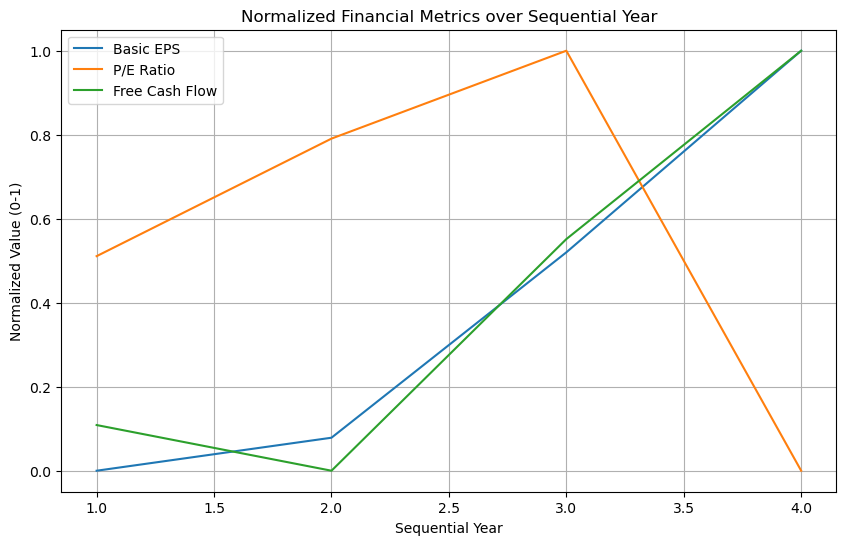

In [ ]:
import numpy as np
metrics_to_scale = ['Basic EPS', 'P/E Ratio', 'Free Cash Flow']

for metric in metrics_to_scale:
    data = weighted_metrics_technology_df[metric].copy()

    # Special case: exclude negative or invalid P/E values only for scaling
    if metric == 'P/E Ratio':
        valid_mask = data > 0  # keep only positive P/E for scaling
        min_val = data[valid_mask].min()
        max_val = data[valid_mask].max()
        scaled = (data - min_val) / (max_val - min_val)
        scaled[~valid_mask] = np.nan  # mark negative or invalid as NaN
    else:
        min_val = data.min()
        max_val = data.max()
        scaled = (data - min_val) / (max_val - min_val)

    weighted_metrics_technology_df[metric + '_scaled'] = scaled

plt.figure(figsize=(10,6))
plt.plot(weighted_metrics_technology_df['Sequential_Year'], weighted_metrics_technology_df['Basic EPS_scaled'], label='Basic EPS')
plt.plot(weighted_metrics_technology_df['Sequential_Year'], weighted_metrics_technology_df['P/E Ratio_scaled'], label='P/E Ratio')
plt.plot(weighted_metrics_technology_df['Sequential_Year'], weighted_metrics_technology_df['Free Cash Flow_scaled'], label='Free Cash Flow')

plt.title('Normalized Financial Metrics over Sequential Year')
plt.xlabel('Sequential Year')
plt.ylabel('Normalized Value (0-1)')
plt.legend()
plt.grid(True)
plt.show()


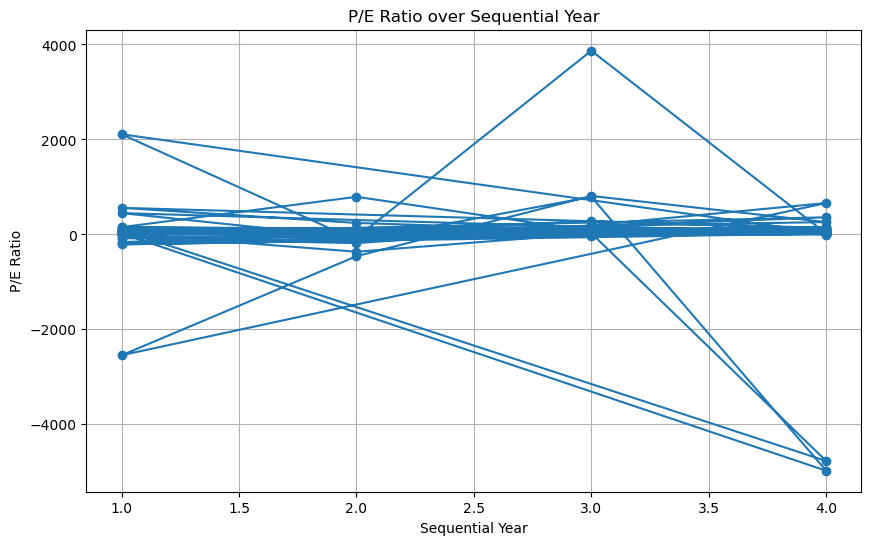

In [ ]:
import matplotlib.pyplot as plt

# Assuming combined_df already has a Sequential_Year column and Basic EPS column
plt.figure(figsize=(10,6))
plt.plot(technology_df['Sequential_Year'], technology_df['P/E Ratio'], marker='o', linestyle='-')

plt.title('P/E Ratio over Sequential Year')
plt.xlabel('Sequential Year')
plt.ylabel('P/E Ratio')
plt.grid(True)
plt.show()

In [ ]:
low_pe_df = technology_df[(technology_df['P/E Ratio'] < 0) & (technology_df['Sequential_Year'] == 4)]
low_pe_df

,Ticker,Company,Sector,Industry,Market Cap,Year,Basic EPS,Free Cash Flow,P/E Ratio,Share Price,Sequential_Year
454,CRWD,"CrowdStrike Holdings, Inc.",Technology,Software - Infrastructure,125505167360,2025,-0.08,1.067906e+09,-4975.875092,398.070007,4
972,INTC,Intel Corporation,Technology,Semiconductors,175636480000,2024,-4.38,-1.565600e+10,-4.577625,20.049999,4
1201,MCHP,Microchip Technology Incorporated,Technology,Semiconductors,34809339904,2025,-0.01,7.721000e+08,-4770.757294,47.707573,4


In [ ]:
metrics_to_scale = ['Basic EPS', 'P/E Ratio', 'Free Cash Flow']

for metric in metrics_to_scale:
    min_val = weighted_metrics_technology_df[metric].min()
    max_val = weighted_metrics_technology_df[metric].max()
    weighted_metrics_technology_df[metric + '_scaled'] = (
        (weighted_metrics_technology_df[metric] - min_val) / (max_val - min_val)
    )

plt.figure(figsize=(10,6))
plt.plot(weighted_metrics_technology_df['Sequential_Year'], weighted_metrics_technology_df['Basic EPS_scaled'], label='Basic EPS')
plt.plot(weighted_metrics_technology_df['Sequential_Year'], weighted_metrics_technology_df['P/E Ratio_scaled'], label='P/E Ratio')
plt.plot(weighted_metrics_technology_df['Sequential_Year'], weighted_metrics_technology_df['Free Cash Flow_scaled'], label='Free Cash Flow')

plt.title('Normalized Financial Metrics over Sequential Year')
plt.xlabel('Sequential Year')
plt.ylabel('Normalized Value (0-1)')
plt.legend()
plt.grid(True)
plt.show()